# Measuring Stub Splaying Angles Over Time
This code is written for the efficient observation and quantification of k-fiber stub splaying. Here, you can label splayed MT bunches, check your labels, and plot the degree of the stub's splaying over time.

In order to import the below packages, they must be downloaded and installed.

In [1]:
import cv2
import math
import matplotlib.pyplot as plt
import moviepy.editor
from moviepy.editor import VideoFileClip
from moviepy.video.tools.tracking import manual_tracking
import numpy as np
import os
import pims
from pims import Frame
import pygame

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def smoothenAngles(smoothAngles, order):
    
    smoothAngles.clear()
    smoothen = []
    counter = 0
    
    for i in range(len(angles)):
        smoothAngles.append(angles[i])
        #smoothen.append([])
    
    while counter<order:
        
        smoothAng0 = (20*smoothAngles[0] + 15*smoothAngles[1] + 6*smoothAngles[2] + smoothAngles[3])/42
        smoothAng1 = (15*smoothAngles[0] + 20*smoothAngles[1] + 15*smoothAngles[2] + 6*smoothAngles[3] + smoothAngles[4])/57
        smoothAng2 = (6*smoothAngles[0] + 15*smoothAngles[1]+ 20*smoothAngles[2] + 15*smoothAngles[3] + 6*smoothAngles[4] + smoothAngles[5])/63
        
        smoothen.append(smoothAng0)
        smoothen.append(smoothAng1)
        smoothen.append(smoothAng2)
        
        for i in range(3,len(angles)-3):
            
            smoothAngI = (smoothAngles[i-3] + 6*smoothAngles[i-2] + 15*smoothAngles[i-1]+ 20*smoothAngles[i] + 15*smoothAngles[i+1] + 6*smoothAngles[i+2] + smoothAngles[i+3])/64
            smoothen.append(smoothAngI)
        
        smoothAngM2 = (smoothAngles[len(angles)-6] + 6*smoothAngles[len(angles)-5] + 15*smoothAngles[len(angles)-4] + 20*smoothAngles[len(angles)-3] + 15*smoothAngles[len(angles)-2] + 6*smoothAngles[len(angles)-1])/63
        smoothAngM1 = (smoothAngles[len(angles)-5] + 6*smoothAngles[len(angles)-4] + 15*smoothAngles[len(angles)-3] + 20*smoothAngles[len(angles)-2] + 15*smoothAngles[len(angles)-1])/57
        smoothAngM0 = (smoothAngles[len(angles)-4] + 6*smoothAngles[len(angles)-3] + 15*smoothAngles[len(angles)-2] + 20*smoothAngles[len(angles)-1])/42
        
        smoothen.append(smoothAngM2)
        smoothen.append(smoothAngM1)
        smoothen.append(smoothAngM0)
        
        smoothAngles.clear()
        
        for i in range(len(smoothen)):
            smoothAngles.append(smoothen[i])
        
        smoothen.clear()
        counter += 1

# Load Movie
Load the selected movie as both a video (.avi file) and a series of images (with pims).

Before employing these two functions, create the necessary files using ImageJ. Since pims.open opens tiff stacks, spacially and temporally crop the original tiff stack and save the new tiff stack. Then, for the VideoFileClip method, save the new tiff stack as a .avi file. Now write the locations of these two new files into their respective functions below.

CITATIONS?

In [30]:
video = VideoFileClip(r'E:\KFiberSplaying\AblationExperiments\IntermediateVids\NewClips\F8_stub.avi').resize(6)
images = pims.open(r'E:\KFiberSplaying\AblationExperiments\IntermediateVids\NewClips\F8_stub.tif')

# Collect Important Information About Video
Calculate and print the number of frames, duration, and frame rate of the video.
These values, along with the video's frame rate, will be useful in later computations.

The frame rate is equal to the inverse of the time it takes for the microscope to image a single frame. This time per frame should be written in your notebook, in order to quickly find the video's frame rate, wiithout having to access the movie's metadata.

In [31]:
frameRate = 1/3.5         # frames/sec for video IN REAL TIME (while imaging on the scope)
frames = video.duration*video.fps          # number of frames in video
duration = frames/frameRate          # duration of video IN REAL TIME (while imaging on the scope)
frames2 = video.duration/frameRate

print(frameRate, frames, duration, video.fps)

0.2857142857142857 14.98 52.43000000000001 7.0


# Set & Test Threshold Angle for Splaying
Use the splayThreshold field to assign a threshold angle for stub splaying. This angle will be used in subsequent cells for determining when the stub can be considered "splayed". Check to make sure that this is an adequate threshold value by viewing an example of two splayed MT bunches, displayed in the pop-up window that will appear upon execution of the cell. When the stub is splayed at a angle larger that what is shown, it will be designated as a "splayed" stub. When the splaying angle is smaller, the stub will be considered to be not "splayed".

If you wish to change the threshold angle, simply change the value of splayThreshold, re-execute the below cell, and repeat the process described above.

NOTE: The user-assigned threshold angle sould not exceed 90 degrees.

In [32]:
splayThreshold = 15          # splay angle threshold (in degrees) to determine whether stub is splayed

# Execute when threshold angle exceeds 90 degrees
if splayThreshold > 90:
    print('Threshold splaying angle should not exceed 90 degrees')          # Message to user to change angle value

# Execute when threshold angle doesn't exceed 90 degrees
else:
    splayThreshRads = math.radians(splayThreshold)          # splay angle in radians
    angleSideX = int(round(50+500*math.cos(splayThreshRads)))          # x-coord of end of angled line 
    angleSideY = int(round(550-500*math.sin(splayThreshRads)))          # y-coord of end of angled line
    
    # Create and edit image of threshold angle
    exampleAngle = np.zeros((600,600,3), np.uint8)          # creates blank black image
    cv2.line(exampleAngle, (50,550), (550,550), (255,255,255), 2)          # draws flat line on bottom of image
    cv2.line(exampleAngle, (50,550), (angleSideX,angleSideY), (255,255,255), 2)          # draws line at threshold angle
    
    # Display sketch of threshold angle
    cv2.imshow('Splay Angle Threshold', exampleAngle)          # displays angle sketch in separate window
    cv2.waitKey()          # holds window until x-ed out
    cv2.destroyAllWindows()          # closes window when x-ed out

# Track Stub's Corners
Using the manual_tracking function, identify the stub's vertex and the ends of its MT fragments that are the most separated at the ablation spot.

Upon execution of the below cell, a separate window will appear, displaying the first frame in the video. Selection of the stub's corners, via clicking, must be made within this window. In order to measure the correct angle, click first on the vertex of the stub and then on the two ablation-side ends. After three clicks in a frame, this frame will be replaced by the next frame. Repeat this process for all frames. Once the stub's corners have been identified for all frames, the separate display window will close, marking the completion of the manual_tracking function.

The output of the below cell is a text file (track.txt), containing the user-produced data from the manual_tracking function. This data is retrieved from the output text file via the next code cell.

The manual_tracking function can be viewed (in its full glory) at the below URL. https://zulko.github.io/moviepy/_modules/moviepy/video/tools/tracking.html#manual_tracking

In [33]:
manual_tracking(video, t1=0, t2=video.end, fps=video.fps, nobjects=3, savefile='F8_stub_track.txt')          # tracks stub's corners
pygame.quit()          # closes display window

# Check Corner Positions & Calculate Splay Angles
Double-check your angle measurements by watching the video, which is displayed in a separate window and includes a sketch of the angle (as given by your execution of manual_tracking). This code cell also computes the splay angle in each frame.

If any of the reconstructed measurement sketches appear to inaccurately reflect the stub's shape, execute the previous code cell. The data in track.txt will be updated, but you should again check these measurements the same way as before.

(In the future you may be able to check your selected corner positions frame-by-frame.)

CITATIONS?

In [34]:
data = open('F8_stub_track.txt')          # load txt file containing the manual_tracking output data for stub corner positions

# Create empty lists to fill with output splaying data
angles = []          # splay angle values
splayTimes = []          # durations of splaying occurances
times = []          # time stamps of video's frames

# Create variables to be used/editted displaying position selections and/or computing splay angles
counter = 0          # variable used to iterate over video's frames
splayT = 0          # duration of current splaying occurance
splayBefore = False          # boolean telling whether stub was splayed (beyond the threshold) in previous frame


# Loop over all lines in txt file - nth (non-empty) line corresponds to data from nth frame of video
for line in data.readlines():
    
    iData = line.split()          # divide line into individual values for time stamp and corner positions
    
    # Execute when line is NOT empty
    if iData[0].isdigit() == True:
        
        # Record data for current frame (extracted from current line)
        t = int(iData[0])/1000*(video.fps/frameRate)          # time stamp
        x1 = int(iData[1])          # vertex x-position
        y1 = int(iData[2])          # vertex y-position
        x2 = int(iData[4])          # first end x-position
        y2 = int(iData[5])          # first end y-position
        x3 = int(iData[7])          # second end x-position
        y3 = int(iData[8])          # second end y-position
        
        # Calculate side lengths of triangle formed by stub corners
        side1 = math.sqrt((x1-x2)**2+(y1-y2)**2)          # one vertex-end side
        side2 = math.sqrt((x1-x3)**2+(y1-y3)**2)          # other vertex-end side
        side3 = math.sqrt((x2-x3)**2+(y2-y3)**2)          # end-end side
        
        # Execute when any stub corners are in same position (stub ends not splayed)
        if side1 == 0 or side2 == 0 or side3 == 0:
            angle = 0          # assign zero for splay angle
        
        # Executed when stub ends are splayed
        else:
            angleRad = math.acos((side1**2+side2**2-side3**2)/(2*side1*side2))          # Compute splay angle (in radians)
            angle = math.degrees(angleRad)          # Convert splay angle value to degrees
            
            # Execute when on last frame and stub splayed
            if counter >= frames-1:
                if splayT != 0:
                    splayTimes.append(splayT)          # append current splaying duration to list
            
            # Execute when not on last frame
            else:
                
                # Execute when splay angle larger than threshold
                if angle > splayThreshold:
                    splayT += 1/frameRate          # increase duration of current splaying by length of one time step
                    splayBefore = True
                
                # Execute when splay angle smaller than threshold
                else:
                    if splayBefore == True:
                        splayTimes.append(splayT)          # append current splaying duration to list (if not zero)
                    splayT = 0          # set duration of current splaying to zero
                    splayBefore = False
        
        # Draw angles on frame
        frame = cv2.resize(images[counter], None, fx=6, fy=6, interpolation=cv2.INTER_CUBIC)          # enlarge image of frame
        cv2.line(frame, (x1,y1), (x2,y2), (0,0,0), 2)          # line on one vertex-end side
        cv2.line(frame, (x1,y1), (x3,y3), (0,0,0), 2)          # line on other vertex-end side
        cv2.circle(frame, (x1,y1), 4, (0,0,0), -1)          # dot on vertex
        cv2.circle(frame, (x2,y2), 4, (0,0,0), -1)          # dot on one end
        cv2.circle(frame, (x3,y3), 4, (0,0,0), -1)          # dot on other end
        
        # Display frame with angle sketch overlaid
        cv2.imshow('Frames', frame)          # display image
        cv2.waitKey(1000)          # holds image until x-ed out of window
        cv2.destroyAllWindows()          # clear image to make way for next frame
        
        # Write data and move to next frame
        times.append(t)          # append time stamp to list
        angles.append(angle)          # append splay angle to list
        iData.clear()          # clear data from current frame
        counter += 1          # iterate to next frame
    
#os.remove('track.txt')          # removes txt file created by manual_tracking from computer (DOESN'T WORK YET)

# Smoothen Splay Angle Data

In [35]:
smoothAngles = []

smoothAngles1 = []

smoothenAngles(smoothAngles, 1)

for i in range(len(angles)):
    smoothAngles1.append(smoothAngles[i])

smoothAngles.clear()

smoothAngles10 = []

smoothenAngles(smoothAngles, 10)

for i in range(len(angles)):
    smoothAngles10.append(smoothAngles[i])

smoothAngles.clear()

smoothAngles100 = []

smoothenAngles(smoothAngles, 100)

for i in range(len(angles)):
    smoothAngles100.append(smoothAngles[i])

# Save Data to txt File
Save the splay angle data, along with the computed splaying durations and timestamps, to a txt file. Please change the name of the file to describe which specific splaying video the data is from. Use the new file to compare with the data from other splayings in another program.

In [36]:
newFile = open('F8_stub.txt','w')          # Create txt file with video-specific name

# List the video's timestamps
newFile.write('Timestamps (s)\n')
for i in range(len(times)):
    newFile.write('{}\n'.format(times[i]))

#newFile.write('\n')          # skip a line

# List the measured splay angles
newFile.write('Splay Angles (degrees)\n')
for i in range(len(angles)):
    newFile.write('{}\n'.format(angles[i]))

# List the smoothened splay angles
newFile.write('Smooth Splay Angles - 1st order (degrees)\n')
for i in range(len(smoothAngles)):
    newFile.write('{}\n'.format(smoothAngles[i]))

# List the smoothened splay angles
newFile.write('Smooth Splay Angles - 10th order (degrees)\n')
for i in range(len(smoothAngles)):
    newFile.write('{}\n'.format(smoothAngles[i]))

# List the smoothened splay angles
newFile.write('Smooth Splay Angles - 100th order (degrees)\n')
for i in range(len(smoothAngles)):
    newFile.write('{}\n'.format(smoothAngles[i]))

#newFile.write('\n')          # skip a line

# List the calculated splaying durations
newFile.write('Splaying Durations\n')
for j in range(len(splayTimes)):
    newFile.write('{}\n'.format(splayTimes[j]))

newFile.close()

# Print Results
Print any/all of the quantities computed in the above cells.

In [203]:
#print("Time Stamps = ",times)          # time steps for every frame
#print()
#print("Splaying Angles = ",angles)          # splay angles for every frame
#print()
#print("Splay Durations = ",splayTimes,"(seconds)")          # durations of splaying occurances

# Plot Splay Angle vs Time
The cell below constructs a scater plot (with invisible dots) of the stub's splaying angle over time with a red line connecting one data point to the next.

In [37]:
times2 = []

for i in range(len(times)):
    times2.append(times[i]/60)


plt.figure(dpi=500)
plt.plot(times2, angles, c='blue')
plt.xlim(0)
plt.ylim(0)
#plt.xticks([0,1,2,3])
#plt.yticks([0,20,40,60,80])
plt.title('Stub Splaying', fontsize=20)          # plot title
plt.xlabel('Time (min)')          # label x-axis
plt.ylabel('Angle (degrees)')          # label y-axis
plt.close()

15


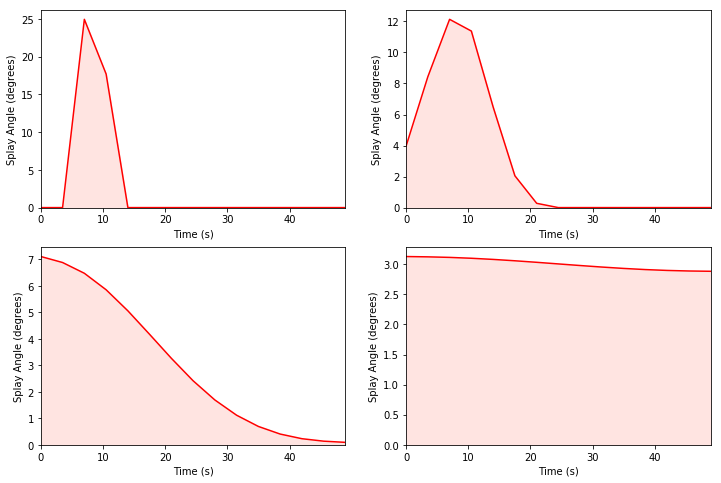

In [38]:
fig = plt.figure(figsize=[12,8])

fig.add_subplot(2,2,1)
plt.plot(times, angles, '-r')          # create plot
plt.fill_between(times, angles, 0, color='mistyrose')
plt.xlim(0,np.amax(times))
plt.ylim(bottom=0)
#plt.title('Stub Splaying', fontsize=20)          # plot title
plt.xlabel('Time (s)')          # label x-axis
plt.ylabel('Splay Angle (degrees)')          # label y-axis
#plt.axis('off')

fig.add_subplot(2,2,2)
plt.plot(times, smoothAngles1, '-r')          # create plot
plt.fill_between(times, smoothAngles1, 0, color='mistyrose')
plt.xlim(0,np.amax(times))
plt.ylim(bottom=0)
#plt.title('Stub Splaying (1st order)', fontsize=20)          # plot title
plt.xlabel('Time (s)')          # label x-axis
plt.ylabel('Splay Angle (degrees)')          # label y-axis
#plt.axis('off')

fig.add_subplot(2,2,3)
plt.plot(times, smoothAngles10, '-r')          # create plot
plt.fill_between(times, smoothAngles10, 0, color='mistyrose')
plt.xlim(0,np.amax(times))
plt.ylim(bottom=0)
#plt.title('Stub Splaying (10th order)', fontsize=20)          # plot title
plt.xlabel('Time (s)')          # label x-axis
plt.ylabel('Splay Angle (degrees)')          # label y-axis
#plt.axis('off')

fig.add_subplot(2,2,4)
plt.plot(times, smoothAngles100, '-r')          # create plot
plt.fill_between(times, smoothAngles100, 0, color='mistyrose')
plt.xlim(0,np.amax(times))
plt.ylim(bottom=0)
#plt.title('Stub Splaying (100th order)', fontsize=20)          # plot title
plt.xlabel('Time (s)')          # label x-axis
plt.ylabel('Splay Angle (degrees)')          # label y-axis
#plt.axis('off')

print(len(smoothAngles10))

# Possible Improvements to Code
1) Draw angles with red lines (or any color other than grayscale)

2) Be able to edit stub corner positions for individual frames

3) Erase text file after extracting data